In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb # type: ignore
import shap

C:\Users\bigni\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

#because of our business aim we decided to treat prediabetes and diabetes as one category - illness
df.loc[df['Diabetes_012']==2, 'Diabetes_012']=1

In [3]:
from sklearn.model_selection import train_test_split

y = np.array(df['Diabetes_012'])
X = df.drop(['Diabetes_012'], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, stratify=Y_val, test_size=0.3, random_state=42)

#for validation group
test_df = X_test.copy()
test_df['Diabetes_012']=Y_test.copy()

#for us to see the results
val_df = X_val.copy()
val_df['Diabetes_012']= Y_val.copy()

#for us to train
train_df = X_train.copy()
train_df['Diabetes_012']=Y_train.copy()

In [4]:
def select_K_best(k,X_t,y):
    X=X_t.copy()
    Y=y
    k_best = SelectKBest(score_func=chi2, k=k)
    fit = k_best.fit(X,Y)
    features = X.columns[fit.get_support(indices=True)].tolist()
    return X[features]

def one_hot_encoding(X):
    A=X.copy()
    encoder = OneHotEncoder(sparse_output=False)

    columns = ['Age','Income','Education']
    encoded = encoder.fit_transform(A[columns])

    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns))
    df_encoded = pd.concat([A.reset_index(drop=True),one_hot_df.reset_index(drop=True)], axis=1)
    df_encoded = df_encoded.drop(columns, axis=1)

    return df_encoded

def change_education_to_name(Education):
    if Education in [1,2]:
        return 'PrimaryEducation'
    elif Education in [3,4]:
        return 'HighSchoolEducation'
    else:
        return 'CollageEducation' #collage not finished and bachelors degrees


def feature_binning(X):
    A= X.copy()
    A['BMI'] = pd.qcut(A['BMI'], q=10, labels=False)
    A['Age'] = pd.qcut(A['Age'], q=7 ,labels=[0,1,2,3,4,5,6])
    A['Education'] =  A['Education'].apply(change_education_to_name)
    return A



In [5]:
from sklearn.metrics import roc_auc_score

X = select_K_best(35,one_hot_encoding(feature_binning(X_train)),Y_train)
used = X.columns.to_list()
Y=Y_train
Xv = one_hot_encoding(feature_binning(X_val))[used]

model = lgb.LGBMClassifier(subsample=0.75, 
                           reg_lambda=0.5, 
                           reg_alpha=0.1, 
                           n_estimators=200, 
                           max_depth=None, 
                           learning_rate=0.05, 
                           colsample_bytree=0.75,
                           num_leaves=30,
                           bagging_freq=3,
                           bagging_fraction=0.75,
                           force_row_wise=True
                           )


model.fit(X, Y)

train_predictions = model.predict_proba(X)
Val_predictions = model.predict_proba(Xv)

auc = roc_auc_score(Y_train, train_predictions[:, 1])
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, Val_predictions[:, 1])
print("AUC for validation set:", auc)

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 27984, number of negative: 149592
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 177576, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.157589 -> initscore=-1.676279
[LightGBM] [Info] Start training from score -1.676279
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value

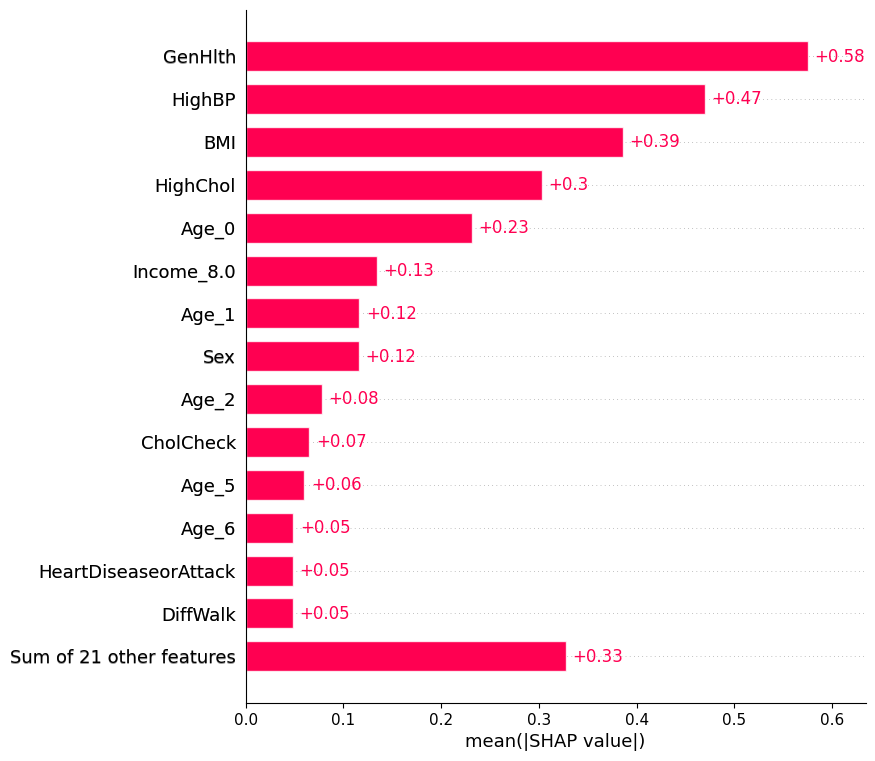

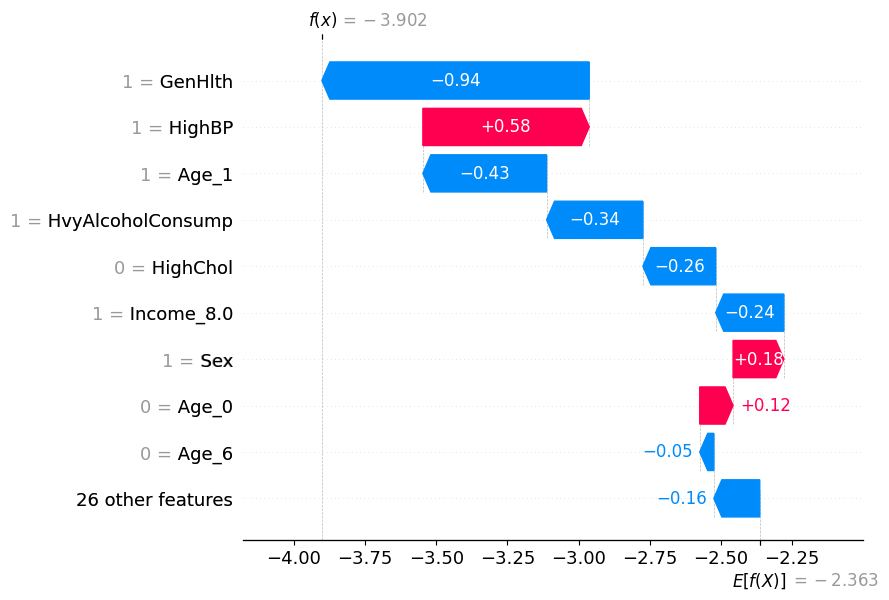

In [6]:
X_sample = X.sample(n=200)
explainer = shap.Explainer(model)
shap_values = explainer(X_sample) 

shap.plots.bar(shap_values,max_display=15) 
shap.waterfall_plot(shap_values[10])

Roc Auc score for the validation df 82.33%

Interpretation of results for patient 10:

* Good GenHlth decreases the risk of diabetes as well as good Blooad breassure, low BMI, good colesterol, high income and sex=0 (being a female)
* Looking at age (we did one hot encoding) we can see that not being too young (Age0 and Age1) increases the risk, but also not being too old (Age6) decreases the risk slighlty